#Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Installing and importing required Libraries

In [2]:
!pip install keras.utils

  Created wheel for keras.utils: filename=keras_utils-1.0.13-cp37-none-any.whl size=2657 sha256=7339721c115a0174f2c6436215929b6cf9fd2a88336548d6473d1e9a07a953a7
  Stored in directory: /root/.cache/pip/wheels/46/25/27/7707005c1cb27e1ffc8277b004ac295e34767b02b44d73d6be
Successfully built keras.utils


In [3]:
!pip install pyspellchecker

     |████████████████████████████████| 2.7MB 23.4MB/s 


In [4]:
!pip install path

In [5]:
!pip install nltk
!pip install gensim

In [6]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time
import absl
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
import keras.utils
from keras.callbacks import ModelCheckpoint

In [7]:
import argparse

from collections import namedtuple
from typing import List
from path import Path

In [8]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [9]:
import tensorflow as tf

#ignore warnings in the output

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


#Defining Character list for encoding

In [11]:
# char_list:   'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# total number of our output classes: len(char_list)
char_list = string.ascii_letters+string.digits
 
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

#Defining Model

In [12]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [13]:
act_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)        590080

#Finding Contours

In [14]:
BBox = namedtuple('BBox', 'x, y, w, h')
DetectorRes = namedtuple('DetectorRes', 'img, bbox')


def detect_words(img: np.ndarray, kernel_size: int, sigma: int, theta: int, min_area: int) -> List[DetectorRes]:
    assert img.ndim == 2
    assert img.dtype == np.uint8

    kernel = get_kernel(kernel_size, sigma, theta)
    img_filtered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
    img_thres = 255 - cv2.threshold(img_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    res = []
    components = cv2.findContours(img_thres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    for c in components:

        if cv2.contourArea(c) < min_area:
            continue

        x, y, w, h = cv2.boundingRect(c)
        crop = img[y:y + h, x:x + w]
        res.append(DetectorRes(crop, BBox(x, y, w, h)))

    return res


def prepare_img(img: np.ndarray, height: int) -> np.ndarray:

    assert img.ndim in (2, 3)
    assert height > 0
    assert img.dtype == np.uint8
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h = img.shape[0]
    factor = height / h
    return cv2.resize(img, dsize=None, fx=factor, fy=factor)


def get_kernel(kernel_size: int, sigma: int, theta: int) -> np.ndarray:

    assert kernel_size % 2  # must be odd size
    half_size = kernel_size // 2

    kernel = np.zeros([kernel_size, kernel_size])
    sigma_x = sigma
    sigma_y = sigma * theta

    # TODO: vectorize!
    for i in range(kernel_size):
        for j in range(kernel_size):
            x = i - half_size
            y = j - half_size

            exp_term = np.exp(-x * 2 / (2 * sigma_x) - y * 2 / (2 * sigma_y))
            x_term = (x * 2 - sigma_x * 2) / (2 * np.math.pi * sigma_x ** 5 * sigma_y)
            y_term = (y * 2 - sigma_y * 2) / (2 * np.math.pi * sigma_y ** 5 * sigma_x)

            kernel[i, j] = (x_term + y_term) * exp_term

    kernel = kernel / np.sum(kernel)
    return kernel

In [15]:
data = []
cropped = []
for filename in os.listdir("/content/drive/MyDrive/data"):
    if  filename.endswith("png") or filename.endswith("jpg") or filename.endswith("jpeg"): 
        data.append("/content/drive/MyDrive/data/" + filename)

for img_data in data:
    img = cv2.imread(img_data, cv2.IMREAD_GRAYSCALE)
    height, width = img.shape
    m = max(height,width)
    img = prepare_img(img,m)

    m*=m
    m*=0.0005

    res = detect_words(img,
                       kernel_size=25,
                       sigma=11,
                       theta=7,
                       min_area=m)
    li = []
    for det in res:
        x = det.bbox.x
        y = det.bbox.y
        h = det.bbox.h
        w = det.bbox.w
        x_w = det.bbox.x + det.bbox.w
        y_h = det.bbox.y + det.bbox.h
        l = [y,y_h,x,x_w]
        li.append(l)
    li.sort()
    note = 0
    l2=[]
    for i in li:
      if i not in l2:
        h=i[1]
      temp=[]
      for j in li:
        if (j[0]<h) and j not in l2:
          temp.append(j)
      temp.sort(key = lambda x: x[2])
      for z in temp:
        l2.append(z)

    for i in l2:
        crop_img = img[i[0]-10:i[1]+10, i[2]-10:i[3]+10]
        cropped.append(crop_img)

    for i,x in zip(cropped,l2):
      plt.imshow(i,cmap='gray')
      plt.show()
      print("\n")

Output hidden; open in https://colab.research.google.com to view.

#Predicting each word in contour

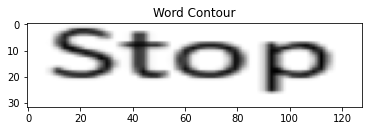

Predicted text =  Stop

After Spell Checker =  Stop


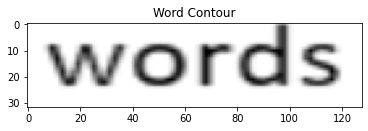

Predicted text =  words

After Spell Checker =  words


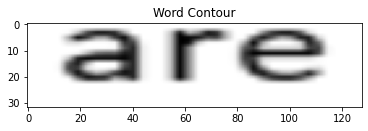

Predicted text =  are

After Spell Checker =  are


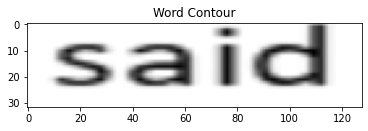

Predicted text =  said

After Spell Checker =  said


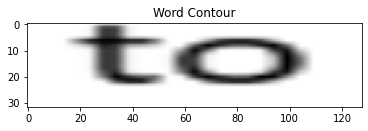

Predicted text =  to

After Spell Checker =  to


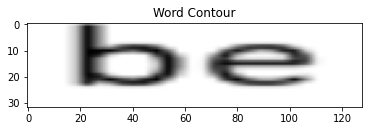

Predicted text =  De

After Spell Checker =  De


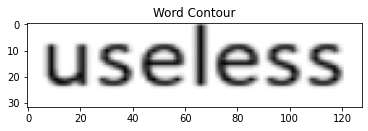

Predicted text =  useless

After Spell Checker =  useless


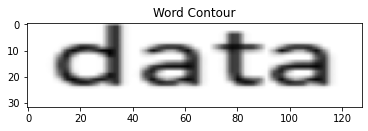

Predicted text =  data

After Spell Checker =  data


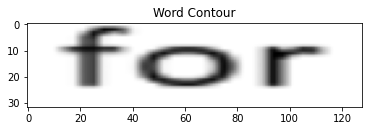

Predicted text =  for

After Spell Checker =  for


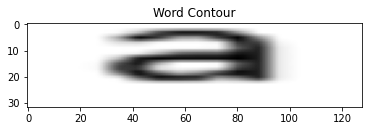

Predicted text =  Cs

After Spell Checker =  is


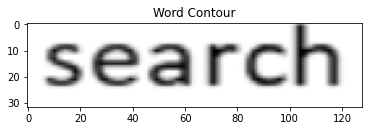

Predicted text =  search

After Spell Checker =  search


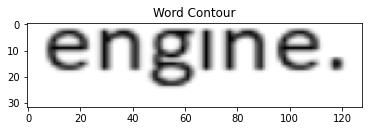

Predicted text =  engines

After Spell Checker =  engines


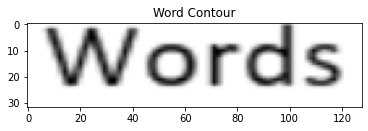

Predicted text =  Words

After Spell Checker =  Words


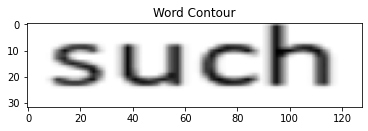

Predicted text =  such

After Spell Checker =  such


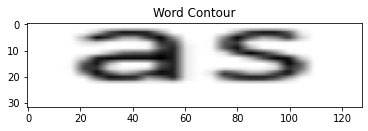

Predicted text =  a

After Spell Checker =  a


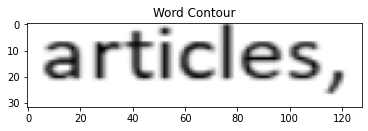

Predicted text =  articles

After Spell Checker =  articles


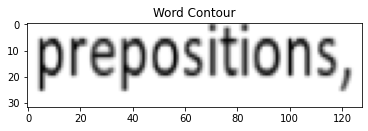

Predicted text =  prepositionss

After Spell Checker =  prepositions


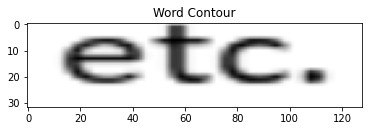

Predicted text =  etcr

After Spell Checker =  etc


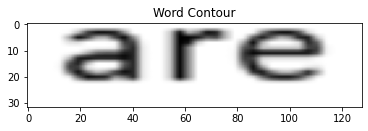

Predicted text =  are

After Spell Checker =  are


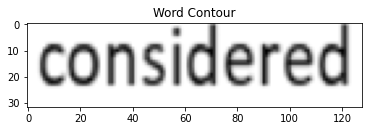

Predicted text =  considered

After Spell Checker =  considered


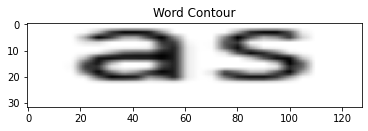

Predicted text =  e

After Spell Checker =  e


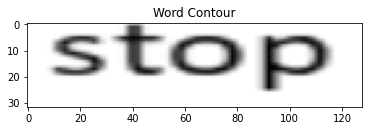

Predicted text =  stop

After Spell Checker =  stop


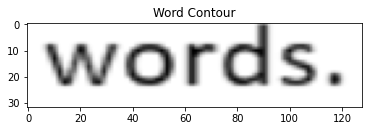

Predicted text =  wordss

After Spell Checker =  words


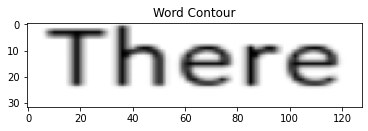

Predicted text =  There

After Spell Checker =  There


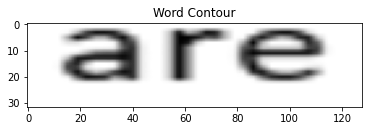

Predicted text =  are

After Spell Checker =  are


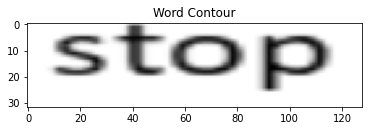

Predicted text =  stop

After Spell Checker =  stop


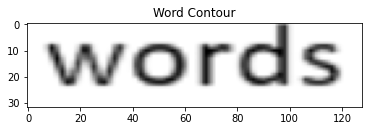

Predicted text =  words

After Spell Checker =  words


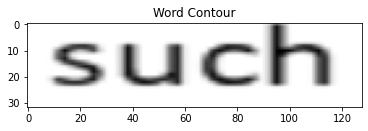

Predicted text =  such

After Spell Checker =  such


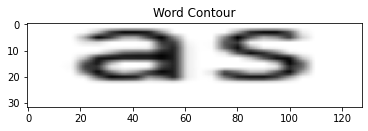

Predicted text =  e

After Spell Checker =  e


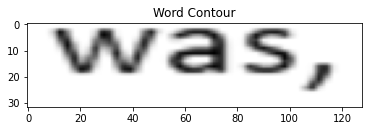

Predicted text =  was

After Spell Checker =  was


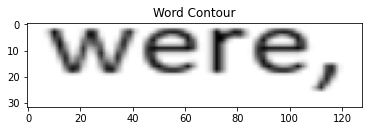

Predicted text =  weres

After Spell Checker =  weres


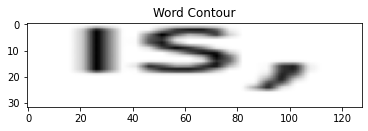

Predicted text =  Is

After Spell Checker =  Is


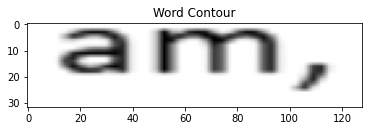

Predicted text =  amy

After Spell Checker =  amy


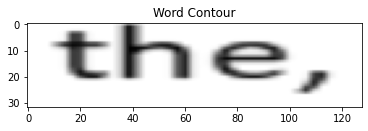

Predicted text =  ther

After Spell Checker =  ther


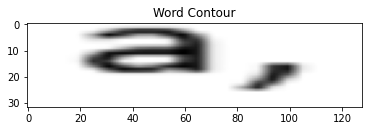

Predicted text =  as

After Spell Checker =  as


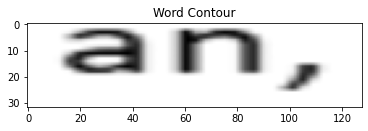

Predicted text =  ans

After Spell Checker =  ans


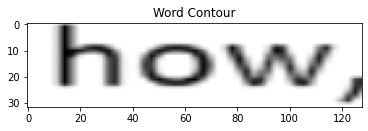

Predicted text =  hows

After Spell Checker =  hows


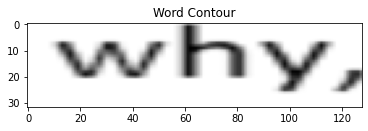

Predicted text =  Whys

After Spell Checker =  Whys


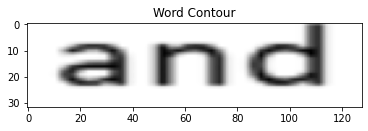

Predicted text =  and

After Spell Checker =  and


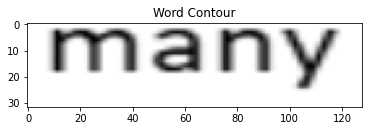

Predicted text =  many

After Spell Checker =  many


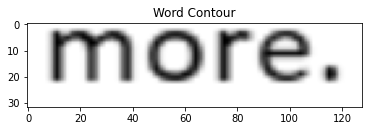

Predicted text =  morer

After Spell Checker =  more


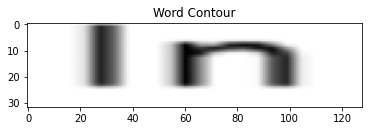

Predicted text =  Un

After Spell Checker =  Un


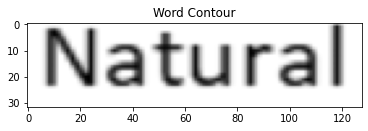

Predicted text =  Natural

After Spell Checker =  Natural


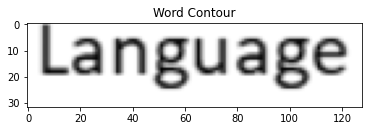

Predicted text =  Language

After Spell Checker =  Language


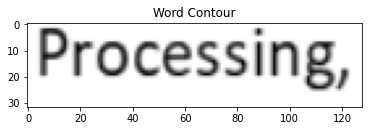

Predicted text =  Processing

After Spell Checker =  Processing


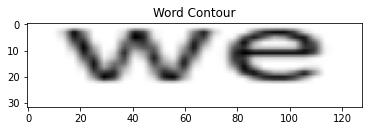

Predicted text =  we

After Spell Checker =  we


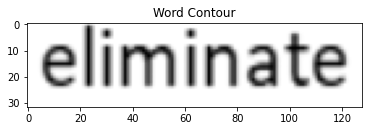

Predicted text =  eliminate

After Spell Checker =  eliminate


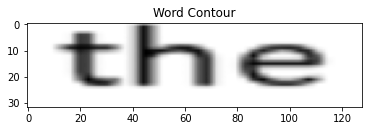

Predicted text =  the

After Spell Checker =  the


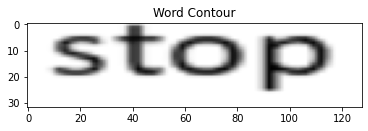

Predicted text =  stop

After Spell Checker =  stop


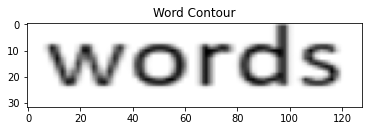

Predicted text =  words

After Spell Checker =  words


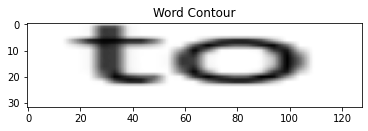

Predicted text =  to

After Spell Checker =  to


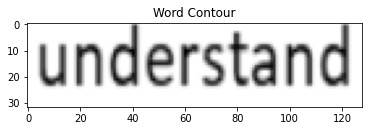

Predicted text =  understand

After Spell Checker =  understand


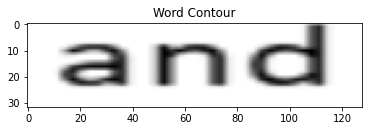

Predicted text =  and

After Spell Checker =  and


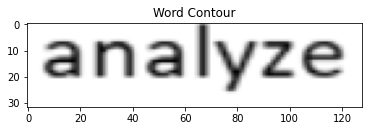

Predicted text =  analyze

After Spell Checker =  analyze


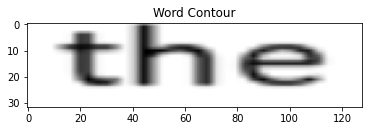

Predicted text =  the

After Spell Checker =  the


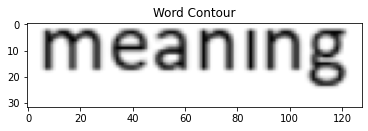

Predicted text =  meaning

After Spell Checker =  meaning


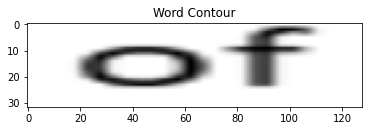

Predicted text =  oi

After Spell Checker =  oi


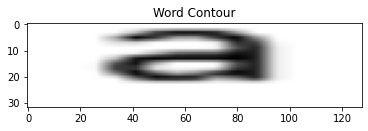

Predicted text =  Cs

After Spell Checker =  is


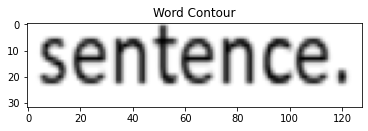

Predicted text =  sentencee

After Spell Checker =  sentence


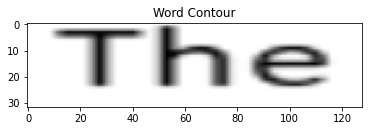

Predicted text =  The

After Spell Checker =  The


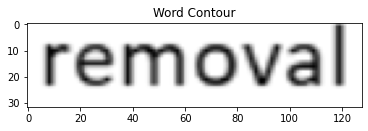

Predicted text =  removal

After Spell Checker =  removal


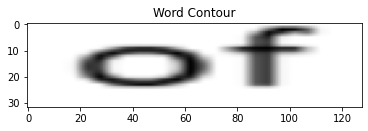

Predicted text =  of

After Spell Checker =  of


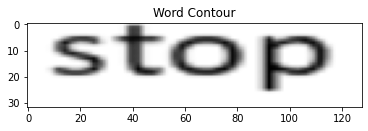

Predicted text =  stop

After Spell Checker =  stop


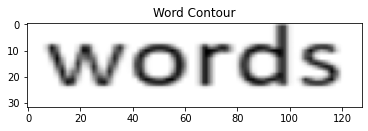

Predicted text =  words

After Spell Checker =  words


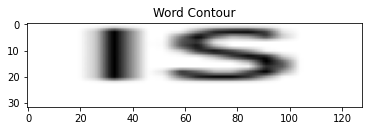

Predicted text =  Is

After Spell Checker =  Is


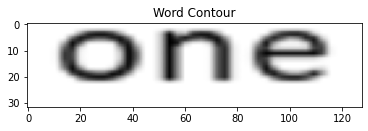

Predicted text =  one

After Spell Checker =  one


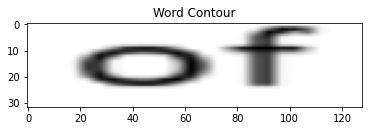

Predicted text =  oi

After Spell Checker =  oi


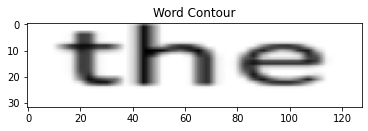

Predicted text =  the

After Spell Checker =  the


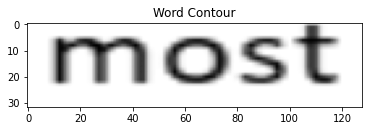

Predicted text =  most

After Spell Checker =  most


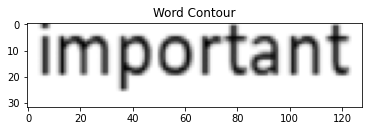

Predicted text =  important

After Spell Checker =  important


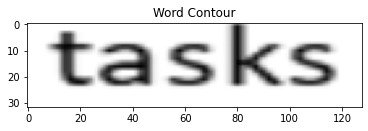

Predicted text =  tasks

After Spell Checker =  tasks


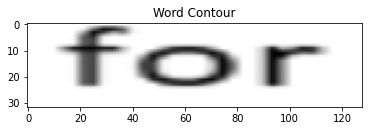

Predicted text =  for

After Spell Checker =  for


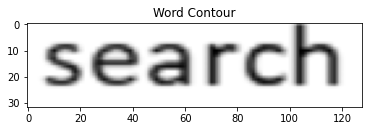

Predicted text =  search

After Spell Checker =  search


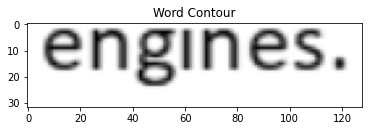

Predicted text =  enginess

After Spell Checker =  engines


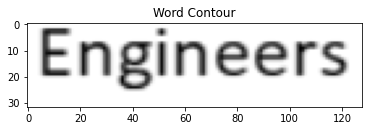

Predicted text =  Engineers

After Spell Checker =  Engineers


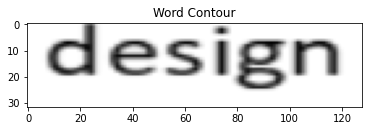

Predicted text =  design

After Spell Checker =  design


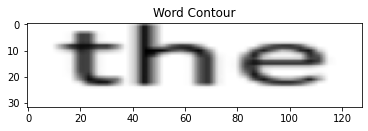

Predicted text =  the

After Spell Checker =  the


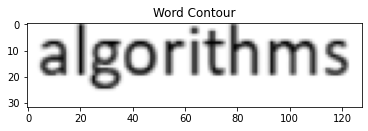

Predicted text =  algorithms

After Spell Checker =  algorithms


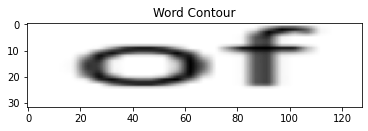

Predicted text =  oi

After Spell Checker =  oi


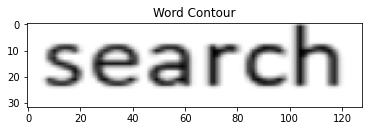

Predicted text =  search

After Spell Checker =  search


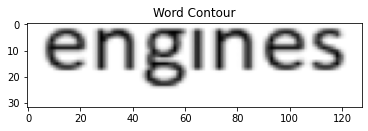

Predicted text =  engines

After Spell Checker =  engines


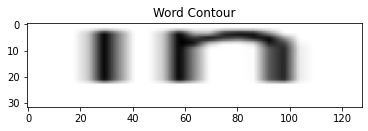

Predicted text =  Im

After Spell Checker =  Im


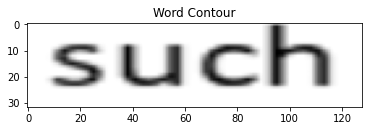

Predicted text =  such

After Spell Checker =  such


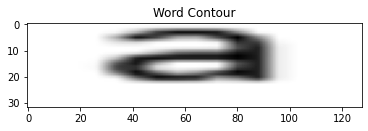

Predicted text =  Cs

After Spell Checker =  is


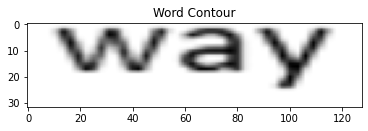

Predicted text =  way

After Spell Checker =  way


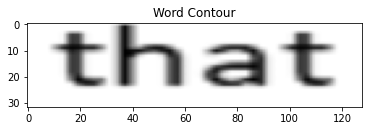

Predicted text =  that

After Spell Checker =  that


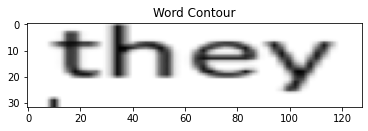

Predicted text =  they

After Spell Checker =  they


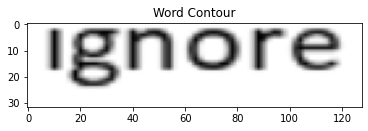

Predicted text =  ngnore

After Spell Checker =  ignore


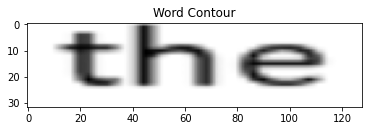

Predicted text =  the

After Spell Checker =  the


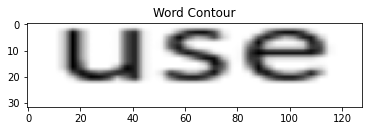

Predicted text =  Use

After Spell Checker =  Use


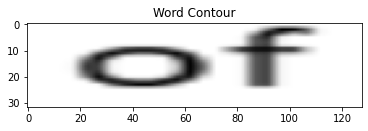

Predicted text =  of

After Spell Checker =  of


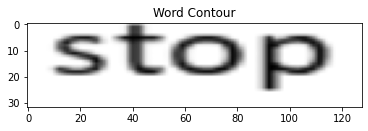

Predicted text =  stop

After Spell Checker =  stop


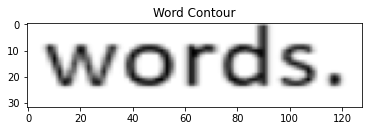

Predicted text =  wordss

After Spell Checker =  words


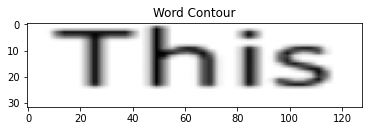

Predicted text =  This

After Spell Checker =  This


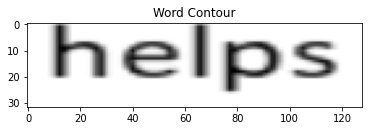

Predicted text =  helps

After Spell Checker =  helps


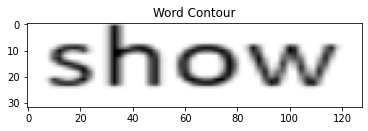

Predicted text =  show

After Spell Checker =  show


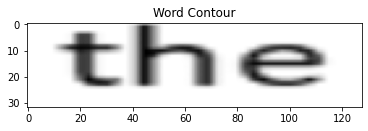

Predicted text =  the

After Spell Checker =  the


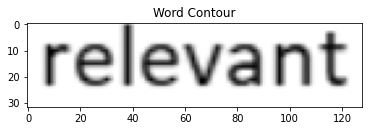

Predicted text =  relevant

After Spell Checker =  relevant


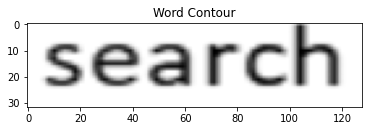

Predicted text =  search

After Spell Checker =  search


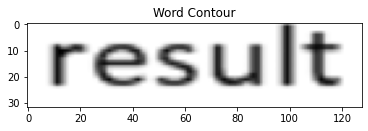

Predicted text =  result

After Spell Checker =  result


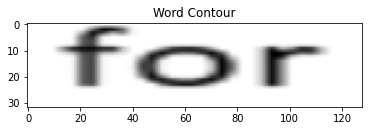

Predicted text =  for

After Spell Checker =  for


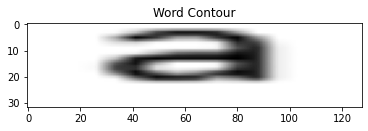

Predicted text =  Cs

After Spell Checker =  is


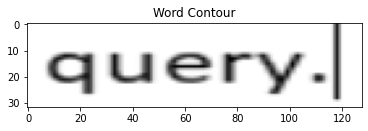

Predicted text =  queryl

After Spell Checker =  query


In [16]:
#using spell checker

from spellchecker import SpellChecker

spell = SpellChecker()


act_model.load_weights('/content/drive/MyDrive/best_model.hdf5')

#loading external image
test = []


for i,x in zip(cropped,l2):
  #img_test = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
  img_test = cv2.resize(i, (128,32))
  img_test = np.expand_dims(img_test, axis = 2)
  img_test = img_test/255
  test.append(img_test)


test = np.array(test)

# predict outputs on validation images
prediction = act_model.predict(test)
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])

i,x = 0,0
string = ""
for x in out:
    plt.imshow(test[i].reshape(32,128), cmap='gray')
    plt.title("Word Contour")
    plt.show()
    print("Predicted text = ", end = " ")
    s = ""
    for p in x:  
        if int(p) != -1:
            s+=char_list[int(p)]
            print(char_list[int(p)], end = '')
  
    s = spell.correction(s)
    string += s
    string += " "
    i += 1
    print("\n")
    print("After Spell Checker = ", s)

In [17]:
print("Final String:",string)

Final String: Stop words are said to De useless data for is search engines Words such a articles prepositions etc are considered e stop words There are stop words such e was weres Is amy ther as ans hows Whys and many more Un Natural Language Processing we eliminate the stop words to understand and analyze the meaning oi is sentence The removal of stop words Is one oi the most important tasks for search engines Engineers design the algorithms oi search engines Im such is way that they ignore the Use of stop words This helps show the relevant search result for is query 


#Using NLTK To comapre two sentences




In [18]:
X = string
Y = "Stop word useless articles prepositions eliminate remove article analyze task meaning understand relevant query"

In [19]:
#converting to lowercase
X = X.lower()
Y = Y.lower()
#Cleaning sentence
def clean_text(text):
    text=re.sub('\w*\d\w*','', text)
    text=re.sub('\n',' ',text)
    text=re.sub(r"http\S+", "", text)
    text=re.sub('[^a-z]',' ',text)
    return text

X = clean_text(X)
Y = clean_text(Y)
print(X)
print(Y)

stop words are said to de useless data for is search engines words such a articles prepositions etc are considered e stop words there are stop words such e was weres is amy ther as ans hows whys and many more un natural language processing we eliminate the stop words to understand and analyze the meaning oi is sentence the removal of stop words is one oi the most important tasks for search engines engineers design the algorithms oi search engines im such is way that they ignore the use of stop words this helps show the relevant search result for is query 
stop word useless articles prepositions eliminate remove article analyze task meaning understand relevant query


In [20]:
#lemmatization

lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

X = lemmatize_sentence(X)
Y = lemmatize_sentence(Y)
print(X)
print(Y)

stop word be say to de useless data for be search engine word such a article preposition etc be consider e stop word there be stop word such e be weres be amy ther as an hows why and many more un natural language processing we eliminate the stop word to understand and analyze the meaning oi be sentence the removal of stop word be one oi the most important task for search engine engineer design the algorithm oi search engine im such be way that they ignore the use of stop word this help show the relevant search result for be query
stop word useless article preposition eliminate remove article analyze task meaning understand relevant query


In [21]:
# tokenization
X_list = word_tokenize(X) 
Y_list = word_tokenize(Y)
print(X_list)
print(Y_list)

['stop', 'word', 'be', 'say', 'to', 'de', 'useless', 'data', 'for', 'be', 'search', 'engine', 'word', 'such', 'a', 'article', 'preposition', 'etc', 'be', 'consider', 'e', 'stop', 'word', 'there', 'be', 'stop', 'word', 'such', 'e', 'be', 'weres', 'be', 'amy', 'ther', 'as', 'an', 'hows', 'why', 'and', 'many', 'more', 'un', 'natural', 'language', 'processing', 'we', 'eliminate', 'the', 'stop', 'word', 'to', 'understand', 'and', 'analyze', 'the', 'meaning', 'oi', 'be', 'sentence', 'the', 'removal', 'of', 'stop', 'word', 'be', 'one', 'oi', 'the', 'most', 'important', 'task', 'for', 'search', 'engine', 'engineer', 'design', 'the', 'algorithm', 'oi', 'search', 'engine', 'im', 'such', 'be', 'way', 'that', 'they', 'ignore', 'the', 'use', 'of', 'stop', 'word', 'this', 'help', 'show', 'the', 'relevant', 'search', 'result', 'for', 'be', 'query']
['stop', 'word', 'useless', 'article', 'preposition', 'eliminate', 'remove', 'article', 'analyze', 'task', 'meaning', 'understand', 'relevant', 'query']


In [22]:
# sw contains the list of stopwords
sw = stopwords.words('english') 
l1 =[];l2 =[]

In [23]:
# remove stop words from the string
X_set = {w for w in X_list if not w in sw} 
Y_set = {w for w in Y_list if not w in sw}
print(X_set)
print(Y_set)

{'preposition', 'etc', 'article', 'stop', 'useless', 'consider', 'weres', 'relevant', 'engineer', 'way', 'un', 'word', 'language', 'sentence', 'one', 'important', 'design', 'use', 'de', 'understand', 'task', 'say', 'oi', 'data', 'analyze', 'natural', 'search', 'algorithm', 'query', 'help', 'many', 'eliminate', 'removal', 'engine', 'ignore', 'ther', 'result', 'amy', 'processing', 'meaning', 'show', 'e', 'im', 'hows'}
{'analyze', 'preposition', 'remove', 'meaning', 'word', 'query', 'article', 'stop', 'useless', 'understand', 'eliminate', 'relevant', 'task'}


In [24]:
# form a set containing keywords of both strings 
rvector = X_set.union(Y_set) 
for w in rvector:
    if w in X_set: l1.append(1) # create a vector
    else: l1.append(0)
    if w in Y_set: l2.append(1)
    else: l2.append(0)
c = 0
print(rvector)
print(l1)
print(l2)

{'preposition', 'remove', 'etc', 'article', 'stop', 'useless', 'consider', 'weres', 'relevant', 'engineer', 'way', 'un', 'word', 'language', 'sentence', 'one', 'important', 'design', 'use', 'de', 'understand', 'task', 'say', 'oi', 'data', 'analyze', 'natural', 'search', 'algorithm', 'query', 'help', 'many', 'eliminate', 'removal', 'engine', 'ignore', 'ther', 'result', 'amy', 'processing', 'meaning', 'show', 'e', 'im', 'hows'}
[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [25]:
# cosine formula 
for i in range(len(rvector)):
        c+= l1[i]*l2[i]
cosine = c / float((sum(l1)*sum(l2))**0.5)
print("similarity: ", cosine)

similarity:  0.5017452060042544
